In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2
import open3d as o3d
from scipy.ndimage.filters import gaussian_filter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def normal_visualization(N):
    image_row = N.shape[0]
    image_col = N.shape[1]
    # converting the array shape to (w*h) * 3 , every row is a normal vetor of one pixel
    N_map = np.copy(np.reshape(N, (image_row, image_col, 3)))
    # Rescale to [0,1] float number
    N_map = (N_map + 1.0) / 2.0
    plt.figure()
    plt.imshow(N_map)
    plt.title('Normal map')

def save_ply(Z,filepath):
    image_row = Z.shape[0]
    image_col = Z.shape[1]
    Z_map = np.reshape(Z, (image_row,image_col)).copy()
    data = np.zeros((image_row*image_col,3),dtype=np.float32)
    # let all point float on a base plane 
    baseline_val = np.min(Z_map)
    Z_map[np.where(Z_map == 0)] = baseline_val
    for i in range(image_row):
        for j in range(image_col):
            idx = i * image_col + j
            data[idx][0] = j
            data[idx][1] = i
            data[idx][2] = Z_map[image_row - 1 - i][j]
    # output to ply file
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data)
    o3d.io.write_point_cloud(filepath, pcd,write_ascii=True)

# show the result of saved ply file
def show_ply(filepath):
    pcd = o3d.io.read_point_cloud(filepath)
    o3d.visualization.draw_geometries([pcd])

def depth_visualization(D):
    image_row = D.shape[0]
    image_col = D.shape[1]
    D_map = np.copy(np.reshape(D, (image_row,image_col)))
    # D = np.uint8(D)
    plt.figure()
    plt.imshow(D_map)
    plt.colorbar(label='Distance to Camera')
    plt.title('Depth map')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')

In [51]:
def load_images(image_number, path):
    h,w, _ = np.array(Image.open(f'{path}pic1.bmp')).shape
    images = np.zeros((h, w, image_number))
    for i in range(image_number):
        img = Image.open(f'{path}pic{i+1}.bmp')
        gray_image = ImageOps.grayscale(img)
        images[:, :, i] = np.array(gray_image)

    return images

def load_lightsource(number, path):
    lights = []
    f = open(f'{path}LightSource.txt')
    for i in range(number):
        line = f.readline()
        result = re.findall(r'-?\d+',line)[1:]
        value = list(map(int, result))
        lights.append(value)

    return np.array(lights)

def cal_normal(images, lights):
    height = images[:,:,0].shape[0]
    width = images[:,:,0].shape[1]
    normals = np.zeros((height,width,3))

    lights = lights / np.linalg.norm(lights, axis = 1).reshape(6,1) #normalize light source to unit vector

    for y in range(height):
        for x in range(width):
            I = images[y, x, :]
            I = I/255.0
            # solve Ax = B, in here A = light source, B = intensity vector, and return normal x
            normal, _, _, _ = np.linalg.lstsq(lights, I, rcond=None)
            albedo = np.linalg.norm(normal)
            normals[y][x] = np.divide(normal, albedo, out=np.zeros_like(normal), where=albedo!=0) # prevent divide by zero

    return normals

def create_mask(images):
    mixed_mask = np.zeros(images.shape[0:2], dtype=int)
    for i in range(images.shape[2]):
        _, mask = cv2.threshold(images[:,:,i], 0, 1, cv2.THRESH_BINARY)
        mask = mask.astype(int)
        mixed_mask = np.bitwise_or(mixed_mask, mask)
    return mixed_mask


In [52]:
def get_surface(normal_vector):
    w = normal_vector.shape[1]
    h = normal_vector.shape[0]
    g1xy = normal_vector[:,:,0]
    g2xy = normal_vector[:,:,1]
    g3xy = normal_vector[:,:,2]
    fx = np.divide(-g1xy, g3xy, out=np.zeros_like(g1xy), where=g3xy!=0)
    fy = np.divide(g2xy, g3xy, out=np.zeros_like(g2xy), where=g3xy!=0) # let y point at left top side, so use positive g2xy to calculate gradient

    # (from left to right) integral along x axis(width)
    h_left2right = np.zeros((h, w))
    h_left2right[:,0] = np.cumsum(fy[:,0], axis=0)
    fx[:,0] = h_left2right[:,0]
    h_left2right = np.cumsum(fx, axis=1)

    # (from right to left) integral along x axis(width)
    h_right2left = np.zeros((h, w))
    fx = np.divide(-g1xy, g3xy, out=np.zeros_like(g1xy), where=g3xy!=0)
    for y in range(h):
        for x in range(w-2, -1, -1):
            h_right2left[y,x] = h_right2left[y,x+1] - fx[y,x+1]

    # (from top to bottom) integral along y axis(height)
    h_top2bottom = np.zeros((h, w))
    h_top2bottom[0,:] = np.cumsum(fx[0,:])
    fy[0,:] = h_top2bottom[0,:]
    h_top2bottom = np.cumsum(fy, axis=0)

    # (from bottom to top) integral along y axis(height)
    h_bottom2top = np.zeros((h, w))
    fy = np.divide(g2xy, g3xy, out=np.zeros_like(g2xy), where=g3xy!=0) # let y point at left top side 
    for x in range(w):
        for y in range(h-2, -1, -1):
            h_bottom2top[y,x] = h_bottom2top[y+1,x] - fy[y+1,x]

    return h_left2right, h_right2left, h_top2bottom, h_bottom2top

def weighted_surface(h_left2right, h_right2left, h_top2bottom, h_bottom2top):
    w = h_left2right.shape[1]
    h = h_left2right.shape[0]
    heightmap_x = np.zeros((h, w))
    heightmap_y = np.zeros((h, w))
    heightmap_xy = np.zeros((h, w))

    # get
    for y in range(h):
        for x in range(w):
            ratio_x = x / w
            heightmap_x[y,x] = (1-ratio_x)*h_left2right[y,x] + ratio_x*h_right2left[y,x]

    for y in range(h):
        for x in range(w):
            ratio_y = y / h
            heightmap_y[y,x] = (1-ratio_y)*h_top2bottom[y,x] + ratio_y*h_bottom2top[y,x]

    for y in range(h):
        for x in range(w):
            ratio_x = x / w / 2.0
            ratio_y = y / h / 2.0
            heightmap_xy[y,x] = (0.5-ratio_y)*h_top2bottom[y,x] + ratio_y*h_bottom2top[y,x] \
                                + (0.5-ratio_x)*h_left2right[y,x] + ratio_x*h_right2left[y,x]

    return heightmap_x, heightmap_y, heightmap_xy


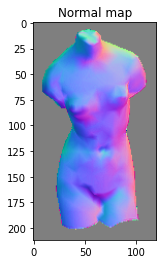

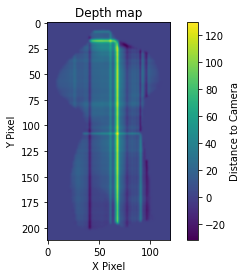

In [95]:
images = load_images(6,"./test/venus/")
lights = load_lightsource(6,"./test/venus/")
mask =  create_mask(images)

normal_vector = cal_normal(images, lights)
normal_visualization(normal_vector)

h_left2right, h_right2left, h_top2bottom, h_bottom2top = get_surface(normal_vector)
heightmap_x, heightmap_y, heightmap_xy = weighted_surface(h_left2right, h_right2left, h_top2bottom, h_bottom2top)

avg_heightmap = (h_left2right + h_right2left + h_top2bottom + h_bottom2top)/4 * mask
blurred = gaussian_filter(avg_heightmap, sigma=1)
depth_visualization(blurred)


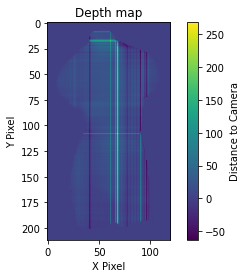

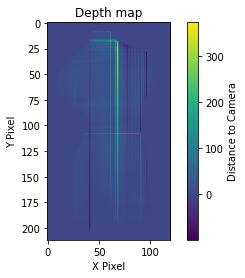

In [84]:
depth_visualization(avg_heightmap)
depth_visualization(heightmap_xy*mask)

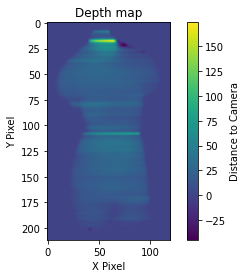

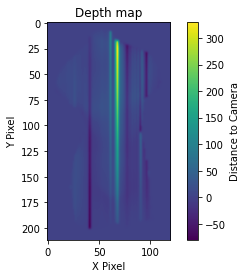

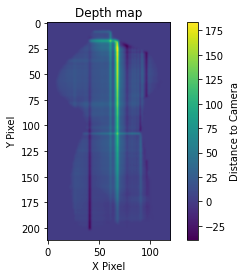

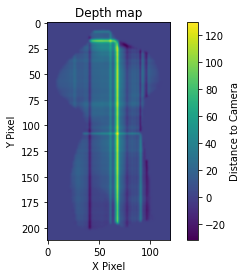

In [56]:
heightmap_x = gaussian_filter(heightmap_x * mask, sigma=1)
heightmap_y = gaussian_filter(heightmap_y * mask, sigma=1)
heightmap_xy = gaussian_filter(heightmap_xy * mask, sigma=1)
avg_heightmap = gaussian_filter(avg_heightmap * mask, sigma=1)

#h_bottom2top = h_bottom2top * mask
depth_visualization(heightmap_x)
#depth_visualization(avg_x * mask)
depth_visualization(heightmap_y)
depth_visualization(heightmap_xy)
#depth_visualization(avg_y * mask)
depth_visualization(avg_heightmap)

In [97]:
save_ply(heightmap_xy*mask,"./venus.ply")
show_ply("./venus.ply")